# Goodreads Books Reviews

> "NLP on Book Reviews"

- toc: true
- branch: master
- badges: true
- comments: true
- categories: [kaggle, jupyter, community, data, science, competition, books, reviews, text, processing]
- hide: false

In [36]:
# Installing the modules

!pip3 install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
# Installing the modules

import numpy as np
import pandas as pd
import seaborn as sns
import category_encoders as ce

from zipfile import ZipFile
from matplotlib import pyplot as plt

from sklearn.tree import DecisionTreeClassifier

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Config

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 7)

In [3]:
# Create kaggle folder

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
# Test the command

!kaggle competitions download -c goodreads-books-reviews-290312

 98% 625M/635M [00:25<00:00, 43.9MB/s]
100% 635M/635M [00:25<00:00, 26.6MB/s]


In [5]:
# Extract the zip file

with ZipFile('/content/goodreads-books-reviews-290312.zip', 'r') as zf:
    zf.extractall('./')

In [4]:
# Constants

target_col = 'rating'

## Loading the data

In [5]:
# Load the data

train = pd.read_csv('/content/goodreads_train.csv')
train.head()

,user_id,book_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments
0,8842281e1d1347389f2ab93d60773d4d,18245960,dfdbb7b0eb5a7e4c26d59a937e2e5feb,5,This is a special book. It started slow for ab...,Sun Jul 30 07:44:10 -0700 2017,Wed Aug 30 00:00:26 -0700 2017,Sat Aug 26 12:05:52 -0700 2017,Tue Aug 15 13:23:18 -0700 2017,28,1
1,8842281e1d1347389f2ab93d60773d4d,16981,a5d2c3628987712d0e05c4f90798eb67,3,Recommended by Don Katz. Avail for free in Dec...,Mon Dec 05 10:46:44 -0800 2016,Wed Mar 22 11:37:04 -0700 2017,NaN,NaN,1,0
2,8842281e1d1347389f2ab93d60773d4d,28684704,2ede853b14dc4583f96cf5d120af636f,3,"A fun, fast paced science fiction thriller. I ...",Tue Nov 15 11:29:22 -0800 2016,Mon Mar 20 23:40:27 -0700 2017,Sat Mar 18 23:22:42 -0700 2017,Fri Mar 17 23:45:40 -0700 2017,22,0
3,8842281e1d1347389f2ab93d60773d4d,27161156,ced5675e55cd9d38a524743f5c40996e,0,Recommended reading to understand what is goin...,Wed Nov 09 17:37:04 -0800 2016,Wed Nov 09 17:38:20 -0800 2016,NaN,NaN,5,1
4,8842281e1d1347389f2ab93d60773d4d,25884323,332732725863131279a8e345b63ac33e,4,"I really enjoyed this book, and there is a lot...",Mon Apr 25 09:31:23 -0700 2016,Mon Apr 25 09:31:23 -0700 2016,Sun Jun 26 00:00:00 -0700 2016,Sat May 28 00:00:00 -0700 2016,9,1


In [6]:
# Load the test data

test = pd.read_csv('/content/goodreads_test.csv')
test.head()

,user_id,book_id,review_id,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments
0,b9450d1c1f97f891c392b1105959b56e,7092507,5c4df7e70e9b438c761f07a4620ccb7c,** spoiler alert ** \n This is definitely one ...,Sat Nov 10 06:06:13 -0800 2012,Sun Nov 11 05:38:36 -0800 2012,Sun Nov 11 05:38:36 -0800 2012,Sat Nov 10 00:00:00 -0800 2012,1,0
1,b9450d1c1f97f891c392b1105959b56e,5576654,8eaeaf13213eeb16ad879a2a2591bbe5,"** spoiler alert ** \n ""You are what you drink...",Fri Nov 09 21:55:16 -0800 2012,Sat Nov 10 05:41:49 -0800 2012,Sat Nov 10 05:41:49 -0800 2012,Fri Nov 09 00:00:00 -0800 2012,1,0
2,b9450d1c1f97f891c392b1105959b56e,15754052,dce649b733c153ba5363a0413cac988f,Roar is one of my favorite characters in Under...,Fri Nov 09 00:25:50 -0800 2012,Sat Nov 10 06:14:10 -0800 2012,Sat Nov 10 06:14:10 -0800 2012,Fri Nov 09 00:00:00 -0800 2012,0,0
3,b9450d1c1f97f891c392b1105959b56e,17020,8a46df0bb997269d6834f9437a4b0a77,** spoiler alert ** \n If you feel like travel...,Thu Nov 01 00:28:39 -0700 2012,Sat Nov 03 11:35:22 -0700 2012,Sat Nov 03 11:35:22 -0700 2012,Thu Nov 01 00:00:00 -0700 2012,0,0
4,b9450d1c1f97f891c392b1105959b56e,12551082,d11d3091e22f1cf3cb865598de197599,3.5 stars \n I read and enjoyed the first two ...,Thu Oct 18 00:57:00 -0700 2012,Mon Apr 01 23:00:51 -0700 2013,Sat Mar 30 00:00:00 -0700 2013,Fri Mar 29 00:00:00 -0700 2013,0,0


## Exploratory Data Analysis

In [7]:
# Inspecting the data

train.info()
train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900000 entries, 0 to 899999
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       900000 non-null  object
 1   book_id       900000 non-null  int64 
 2   review_id     900000 non-null  object
 3   rating        900000 non-null  int64 
 4   review_text   900000 non-null  object
 5   date_added    900000 non-null  object
 6   date_updated  900000 non-null  object
 7   read_at       808234 non-null  object
 8   started_at    625703 non-null  object
 9   n_votes       900000 non-null  int64 
 10  n_comments    900000 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 75.5+ MB


,book_id,rating,n_votes,n_comments
count,9.000000e+05,900000.000000,900000.000000,900000.000000
mean,1.344145e+07,3.689639,3.294381,1.016656
std,9.357863e+06,1.252583,17.873553,5.963821
min,1.000000e+00,0.000000,-3.000000,-1.000000
25%,6.340471e+06,3.000000,0.000000,0.000000
50%,1.344203e+07,4.000000,0.000000,0.000000
75%,2.057897e+07,5.000000,2.000000,0.000000
max,3.632868e+07,5.000000,3222.000000,1335.000000


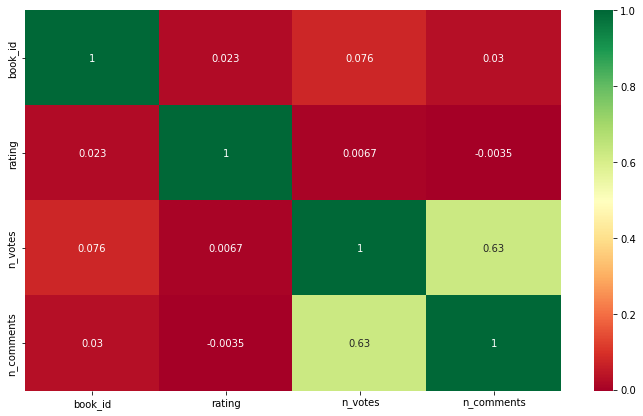

In [8]:
# Correlation heatmap

sns.heatmap(train.corr(), annot=True, vmax=1, cmap='RdYlGn')

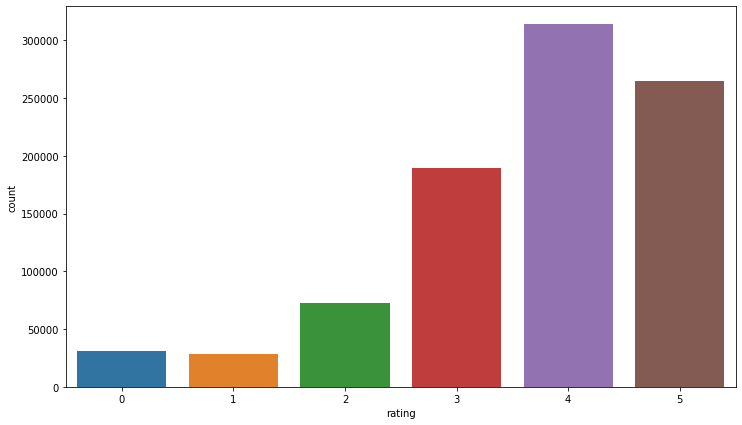

In [9]:
# Distribution of ratings

sns.countplot(x='rating', data=train)

## Feature Engineering

The distributions of `n_votes` and `n_comments` columns are right skewed(highly). So let's do a log transformation to spread it across a larger range, which makes it more comfortable for a machine learning algorithm to extract pattern from it.

In [10]:
# Log transformation

train['n_votes_log'] = np.log(train['n_votes']+0.01).fillna(0)
test['n_votes_log'] = np.log(test['n_votes']+0.01).fillna(0)
train['n_comments_log'] = np.log(train['n_comments']+0.01).fillna(0)
test['n_comments_log'] = np.log(test['n_comments']+0.01).fillna(0)

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [11]:
# Encoding the categorical variables

cat_cols = ['book_id', 'user_id']

for col in cat_cols:
    encoder = ce.cat_boost.CatBoostEncoder()

    encoder.fit(train[col].astype('object'), train[target_col])
    train[f"{col}_encode"] = encoder.transform(train[col]).fillna(0)
    test[f"{col}_encode"] = encoder.transform(test[col]).fillna(0)

In [12]:
# Missing values

if train.isna().any().any():
    missing_cols = train.columns[train.isna().any()]
    print(f"Columns which contains missing values are {missing_cols.tolist()}")
    print(train[missing_cols].isna().sum()/train.shape[0])
else:
    print("No Missing Values")

Columns which contains missing values are ['read_at', 'started_at']
read_at       0.101962
started_at    0.304774
dtype: float64


## Modelling

In [14]:
# Fitting the model

cols2 = ["n_votes_log", "n_comments_log", "n_votes", "n_comments", "book_id_encode", "user_id_encode"]

model = DecisionTreeClassifier()
model.fit(train[cols2], train[target_col])

DecisionTreeClassifier()

In [20]:
# Predictions from the model

test_pred = model.predict(test[cols2])

In [16]:
# Evaluation

print(f"Training Accuracy: {model.score(train[cols2], train['rating'])}")

Training Accuracy: 0.9941722222222222


In [21]:
# Making a submission file

submission = pd.read_csv('/content/goodreads_sample_submission.csv')
submission['rating'] = test_pred
submission.to_csv('output.csv', index=False)

In [22]:
# Submission

!kaggle competitions submit -c goodreads-books-reviews-290312 -f output.csv -m "dt"

100% 16.0M/16.0M [00:08<00:00, 1.88MB/s]
Successfully submitted to Goodreads Books Reviews